In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import shap
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf
from IPython.display import Image, display

import warnings
warnings.filterwarnings("ignore")

/home/jupyter/vertex-pipelines-starter-kit/venv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read Data

In [2]:
from components.base_images.utils.storage import read_from_gcs

In [3]:
input_bucket_raw = "vertex-pipelines-tutorial-raw" 

In [4]:
sales_train = read_from_gcs(input_bucket_raw, "sales_train.csv") #pd.read_csv('data/sales_train.csv')
sales_inference = read_from_gcs(input_bucket_raw, "sales_inference.csv")  #pd.read_csv('data/sales_inference.csv')
prices = read_from_gcs(input_bucket_raw, "prices.csv")  #pd.read_csv('data/prices.csv')
calendar = read_from_gcs(input_bucket_raw, "calendar.csv")  #pd.read_csv('data/calendar.csv')

id_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

In [5]:
sales_train.shape, sales_inference.shape, prices.shape, calendar.shape

((30490, 1918), (30490, 19), (6658181, 4), (1927, 14))

# Preprocessing

In [6]:
# Select store CA_1 only
sales_train = sales_train.loc[sales_train['store_id'] == 'CA_1']

In [7]:
sales_train.shape

(3049, 1918)

In [8]:
# Concatenate train and inference data for pre-processing and feature engineering
df = sales_train.merge(sales_inference, how='left', on=id_cols)
del sales_train
del sales_inference

In [9]:
from components.base_images.tutorial.preprocessing.prepare import (
    melt_sales_data,
    reduce_memory,
    create_release_date_column,
    merge_sales_calendar,
    format_calendar_data,
    filter_out_sales_before_release_date,
    merge_sales_prices
)

In [10]:
df = df.pipe(melt_sales_data, id_cols) \
       .pipe(reduce_memory, id_cols) \
       .pipe(create_release_date_column, prices = prices) \
       .pipe(merge_sales_calendar, calendar = format_calendar_data(calendar)) \
       .pipe(filter_out_sales_before_release_date) \
       .pipe(merge_sales_prices, prices = prices)


Mem. usage decreased to 89.74 Mb (27.3% reduction)


In [11]:
# Set categorical columns
for col in id_cols:
    df[col] = pd.Categorical(df[col])


In [12]:
print(df.shape)
df.head()

(4745581, 17)


,item_id,dept_id,cat_id,store_id,state_id,sales,release,date,wm_yr_wk,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12.0,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,0.46
1,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2.0,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,1.56
2,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,3.17
3,HOBBIES_1_012,HOBBIES_1,HOBBIES,CA_1,CA,0.0,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,5.98
4,HOBBIES_1_015,HOBBIES_1,HOBBIES,CA_1,CA,4.0,0,2011-01-29,11101,NaN,NaN,NaN,NaN,0,0,0,0.70


# Features Engineering

In [13]:
from components.base_images.tutorial.features_engineering.time_features import get_time_features

In [14]:
df = get_time_features(df)

In [15]:
for col in ['dayofweek', 'month', 'weekend', 'year_month']:
    df[col] = pd.Categorical(df[col])

In [16]:
from components.base_images.tutorial.features_engineering.lags_and_rolling import get_lags, aggregate_lags

In [17]:
df = get_lags(df=df, lags=range(14,35))
df = get_lags(df=df, lags=[365])

for granularity in ['cat_id', 'dept_id']:
    df = aggregate_lags(df=df, lags=range(14,35), group_by=granularity)
    df = aggregate_lags(df=df, lags=[365], group_by=granularity)

In [18]:
from components.base_images.tutorial.features_engineering.lags_and_rolling import get_rolling_means

In [19]:
for granularity in ['', '_cat_id', '_dept_id']:
    df = get_rolling_means(df=df, lags=range(14,21), granularity=granularity)
    df = get_rolling_means(df=df, lags=range(21,28), granularity=granularity)
    df = get_rolling_means(df=df, lags=range(28,35), granularity=granularity)

In [20]:
for granularity in ['', '_cat_id', '_dept_id']:
    df = df.drop([f'sales_lag_{i}{granularity}' for i in range(21,35)], axis=1)

In [21]:
from components.base_images.tutorial.features_engineering.price_features import get_pricing_features

In [22]:
price_agg = [
    # Price difference with the other products sold the same day in the same store
    ['date', 'store_id'],
    # Price difference with the other products sold the same day in the same store and category
    ['date', 'store_id', 'cat_id'],
    # Price difference with the other products sold the same day in the same store and sub-category
    ['date', 'store_id', 'dept_id'],
    # Price difference with the average historical price for this product in this store
    ['item_id', 'store_id'],
]

for group_by in price_agg:
    df = get_pricing_features(df, group_by)

## Split

In [23]:
validation_start_date = '2016-04-01'


In [24]:
X_train = df.loc[df['date'] < validation_start_date]
X_val = df.loc[(df['date'] >= validation_start_date) & (~pd.isnull(df['sales']))]
X_inference = df.loc[pd.isnull(df['sales'])]

## Clean 

In [25]:
unnecessary_cols = ['date', 'store_id', 'state_id', 'sales']
X_train, y_train = X_train.drop(unnecessary_cols, axis=1), X_train[['sales']].values
X_val, y_val = X_val.drop(unnecessary_cols, axis=1), X_val[['sales']].values
X_inference = X_inference.drop(unnecessary_cols, axis=1)

In [26]:
X_train.shape, X_val.shape, X_inference.shape

((4629719, 58), (73176, 58), (42686, 58))

# Training

In [27]:
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_val,y_val)

lgb_params = {'metric': 'rmse', 'n_jobs': -1, 'num_boost_round': 2000, 'objective': 'regression'}
model = lgb.train(lgb_params, train_data, early_stopping_rounds=200, valid_sets=[valid_data], verbose_eval=100)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.689377 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12277
[LightGBM] [Info] Number of data points in the train set: 4629719, number of used features: 58
[LightGBM] [Info] Start training from score 1.638408
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.1446
[200]	valid_0's rmse: 2.14643
Early stopping, best iteration is:
[66]	valid_0's rmse: 2.14063


# Evaluation

In [28]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)

In [29]:
from components.base_images.tutorial.evaluation.evaluate import evaluate

In [30]:
evaluate(y_train, y_pred_train, 'training')

Performance on training set:
FA = 0.5112150762632418
RMSE = 2.525768724460689


In [31]:
evaluate(y_val, y_pred_val, 'validation')

Performance on validation set:
FA = 0.5163575356539406
RMSE = 2.1406304352733576


## Explain

In [32]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

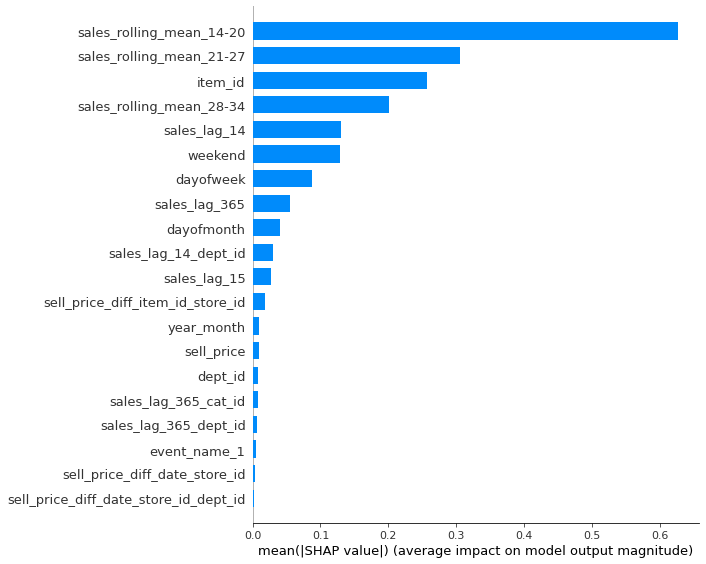

In [33]:
shap.summary_plot(shap_values, X_val, plot_type="bar", show=False)

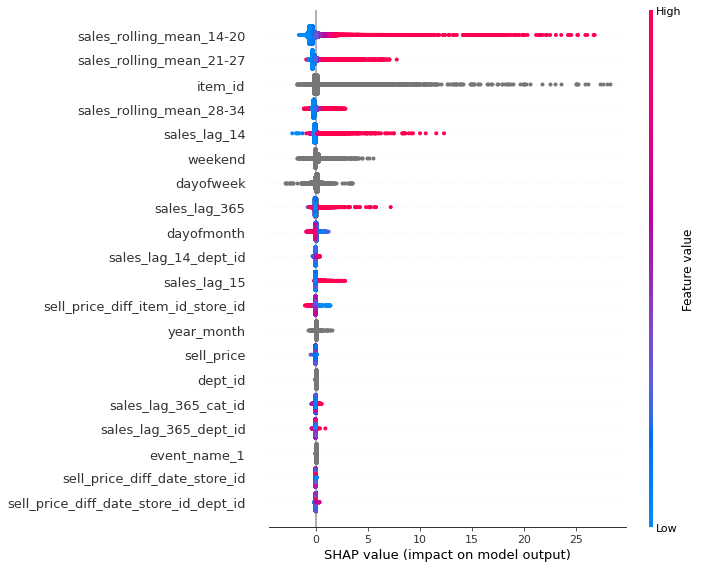

In [34]:
shap.summary_plot(shap_values, X_val)

# Inference

In [35]:
# Concatenation of training and validation datasets
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([pd.Series(y_train.ravel()), pd.Series(y_val.ravel())]).values

# Re-training
train_data = lgb.Dataset(X_train_final, y_train_final)
lgb_params['num_boost_round'] = 150
model = lgb.train(lgb_params, train_data)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.651403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12280
[LightGBM] [Info] Number of data points in the train set: 4702895, number of used features: 58
[LightGBM] [Info] Start training from score 1.636910


In [36]:
# Prediction
X_inference['sales_pred'] = np.array(model.predict(X_inference))

# Build id column for inference data
calendar['dayofmonth'] = calendar.date.dt.day
X_inference = X_inference.merge(calendar[['dayofmonth', 'month', 'year', 'd']], how='left', on=['dayofmonth', 'month', 'year'])
X_inference['id'] = X_inference['item_id'].astype(str) + '_CA_1_' + X_inference['d']
